## 베이스라인 모델 : 단순 선형 회귀
- 목적
    - 비교를 위한 베이스라인 모델 생성
- 핵심
    - Target 값의 분포 확인
    - Simple Linear Regression

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nyc-taxi-demand'

### 데이터 전처리

In [2]:
%%time
query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=query, dialect='standard', project_id=PROJECT_ID)

Downloading: 100%|██████████████████| 87020/87020 [00:07<00:00, 12420.07rows/s]

Wall time: 19.5 s


In [3]:
# 원-핫 인코딩
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

In [4]:
# train/test data 분류 함수
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : 기간(정수 값, ex) 3 -> 3일)
    """
    criteria = max(df['pickup_hour']) - pd.Timedelta(days=period)  # 기준 일 계산
    train_df = df[df['pickup_hour'] <= criteria]
    test_df = df[df['pickup_hour'] > criteria]
    return train_df, test_df

### Linear Regerssion
- Baseline 모델
    - 작업한 모델 중 제일 성능이 낮을 모델, 비교 대상 

### target 분포 확인

In [5]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10037,2015-01-01,1,1,3,0,0,26
1,11238,2015-01-01,1,1,3,0,0,95
2,10170,2015-01-01,1,1,3,0,0,44
3,11221,2015-01-01,1,1,3,0,0,34
4,11371,2015-01-01,1,1,3,0,0,76


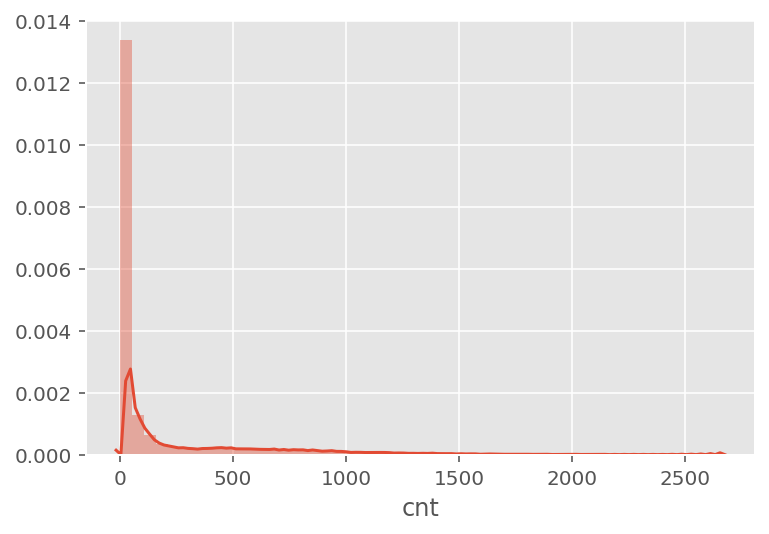

In [6]:
sns.distplot(base_df['cnt'])

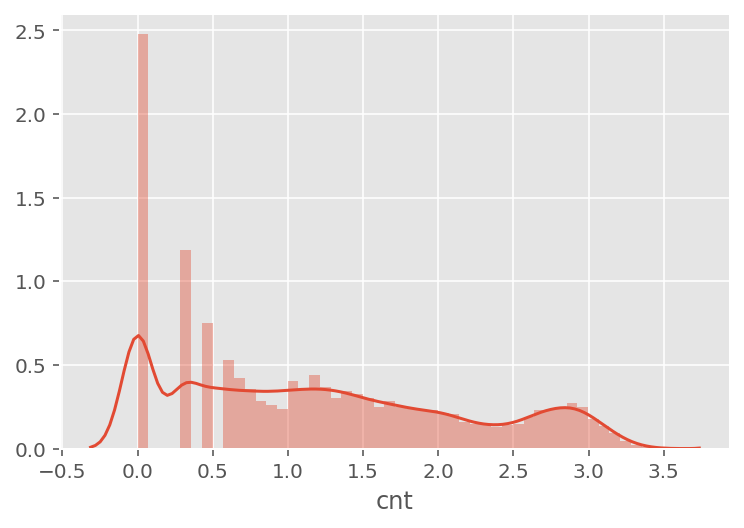

In [7]:
sns.distplot(np.log10(base_df['cnt']))

- cnt 값이 주로 0 ~ 1000 사이에 분포함을 알 수 있음

### Widget으로 Zip code별 운행 빈도 수 파악

In [8]:
def visualize_dist_by_zipcode(df):
    def view_images(zip_code):
        fig, axs = plt.subplots(ncols=2, figsize=(15,5))

        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        ax1 = sns.distplot(raw_data, ax=axs[0]);
        ax2 = sns.distplot(log_data, ax=axs[1]);
        ax1.set_title(f'log is False, zip_code : {zip_code}')
        ax2.set_title(f'log is True, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [9]:
visualize_dist_by_zipcode(base_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### Train / Test set 분할

In [5]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [6]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
68046,11435,2015-01-24 23:00:00,1,24,5,23,1,4
68047,10701,2015-01-24 23:00:00,1,24,5,23,1,1
68048,11373,2015-01-24 23:00:00,1,24,5,23,1,10
68049,11756,2015-01-24 23:00:00,1,24,5,23,1,1
68050,11235,2015-01-24 23:00:00,1,24,5,23,1,3


In [7]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
68051,10027,2015-01-25,1,25,6,0,1,69
68052,10005,2015-01-25,1,25,6,0,1,88
68053,10024,2015-01-25,1,25,6,0,1,514
68054,10065,2015-01-25,1,25,6,0,1,408
68055,11201,2015-01-25,1,25,6,0,1,156


In [8]:
# 불필요한 컬럼 제거
del train_df['pickup_hour']
del test_df['pickup_hour']

In [9]:
y_train = train_df.pop('cnt')
x_train = train_df.copy()
y_test = test_df.pop('cnt')
x_test = test_df.copy()

### Simple Linear Regression
- One-Hot Encoding vs Not

### One-Hot Encoding 없이 그냥 실시할 경우

In [10]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

In [11]:
test_df['pred'] = pred

In [12]:
# 성능 평가 함수
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [13]:
evaluation(y_test, test_df['pred'])

,mape,mae,mse
score,3236.903879,184.008382,76845.096528


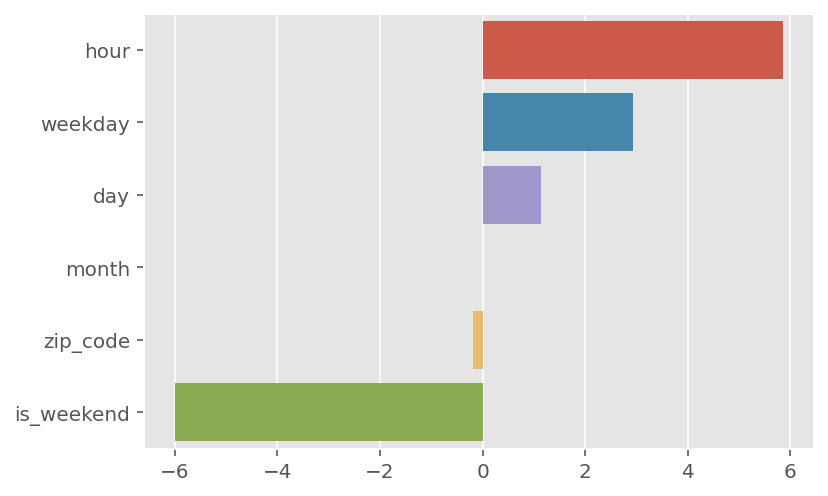

In [14]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)   #  각 변수 별 회귀계수
coef_sort = coef.sort_values(ascending=False)[:10]      #  내림차순 정렬
sns.barplot(x=coef_sort.values , y=coef_sort.index)

### One-Hot Encoding 적용

In [15]:
train_df, test_df = split_train_and_test_period(ohe_df, 7)

In [16]:
del train_df['pickup_hour']
del test_df['pickup_hour']
del train_df['zip_code']
del test_df['zip_code']

y_train = train_df.pop('cnt')
x_train = train_df.copy()
y_test = test_df.pop('cnt')
x_test = test_df.copy()

In [17]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
68051,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68052,1,25,6,0,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68053,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68054,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68055,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

test_df['pred'] = pred

In [19]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred
68051,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.423828
68052,1,25,6,0,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.396484
68053,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.726562
68054,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503.949219
68055,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000


In [20]:
y_test.head()

68051     69
68052     88
68053    514
68054    408
68055    156
Name: cnt, dtype: int64

In [21]:
# test_df[test_df.columns[6:-1]]
# inf를 제외하기 위한 전처리
new_test_df = test_df[np.isfinite(test_df).all(1)]

In [22]:
new_test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred
68051,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.423828
68052,1,25,6,0,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.396484
68053,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.726562
68054,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503.949219
68055,1,25,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000


In [23]:
evaluation(y_test, new_test_df['pred'])

,mape,mae,mse
score,3.322843e+09,3.322851e+07,1.163567e+18


- One-Hot Encoding을 적용할 시, 성능이 오히려 떨어진 것을 관찰할 수 있음
- 위 결과가 사실인 지 판단하기 위해, 아래에서 cnt 값에 log를 씌워서 단순 선형 회귀를 재실시 

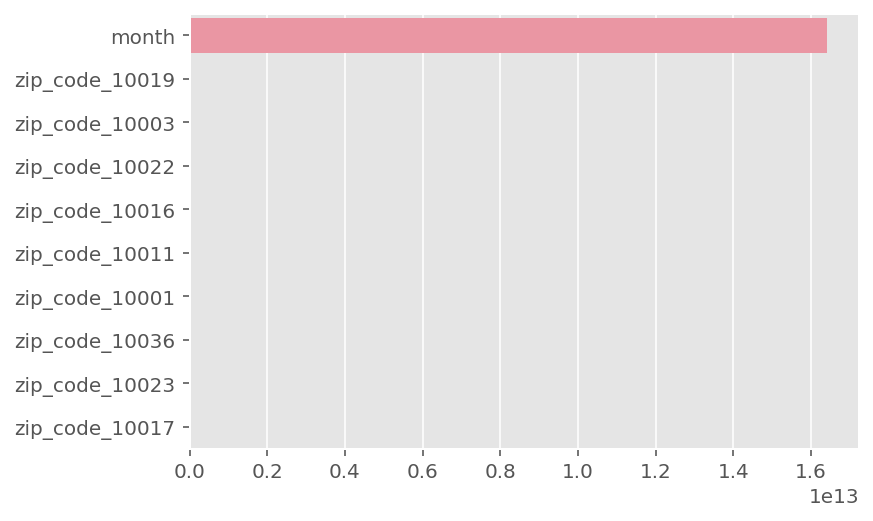

In [24]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

### 종속변수에 log 값을 씌운 상태로 회귀 실시

- One-Hot Encoding 없이 그냥 실시할 경우

In [25]:
# log_cnt 생성
base_df['log_cnt'] = np.log10(base_df['cnt'])

In [29]:
# train/test 데이터 분할
train_df, test_df = split_train_and_test_period(base_df, 7)

In [30]:
# 불필요한 변수 제거
del train_df['pickup_hour']
del test_df['pickup_hour']

In [31]:
# 종속 변수, 독립 변수 분리
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [32]:
# 회귀 적합 및 예측
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.55367312, 1.57263055, 1.55625823, ..., 1.74259237, 0.85159329,
       0.83608267])

In [33]:
# 예측 값 저장
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred

In [34]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [35]:
# 성능 평가 실시
evaluation(y_test_raw, test_df['pred_reverse'])

,mape,mae,mse
score,439.017807,123.936147,92349.281924


- One-Hot Encoding을 적용하여 회귀를 실시할 경우

In [36]:
# log_cnt 컬럼 추가 및 train/test 데이터 분할
ohe_df['log_cnt'] = np.log10(base_df['cnt'])
train_df, test_df = split_train_and_test_period(ohe_df, 7)

In [37]:
# 불필요한 변수 제거
del train_df['pickup_hour']
del test_df['pickup_hour']
del train_df['zip_code']
del test_df['zip_code']

In [38]:
# 종속 변수, 독립 변수 분리
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [39]:
# 회귀 적합 및 예측
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.61724854, 1.63409424, 2.44458008, ..., 1.12405396, 0.37524414,
       0.61038208])

In [40]:
# 예측 값 저장
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred

In [41]:
# 성능 평가 실시
evaluation(y_test_raw, test_df['pred_reverse'])

,mape,mae,mse
score,273.992091,67.526156,26865.365877


- log를 씌운 상태에서 선형 회귀를 실시할 경우, One-Hot Encoding 적용시의 성능이 더 좋은 것을 확인할 수 있음